In [86]:
from OptTensor import OptTensor
from BinaryCrossEntropyLoss import BinaryCrossEntropyLoss
import numpy as np
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
from torch.utils.data import Dataset, random_split, DataLoader
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        sample = {
            "features": self.x[index],
            "label": self.y[index]
        }
        return sample
    def __len__(self):
        return len(self.x)

In [88]:
dim_in = 100
dim_out = [5000, 300, 2]

In [89]:
encodings = {
    'doc2vec': np.load('./data/d2v.npy'),
    'bigram': np.load('./data/pca_bigram.npy'),
    'tfidf': np.load('./data/pca_tfidf.npy'),
    'sent2vec': np.load('./data/s2v.npy'),
    'word2vec': np.load('./data/w2v.npy'),
}
labels = np.load('./data/label.npy')
choices = np.random.choice(np.arange(0, encodings['tfidf'].shape[0]), size=5000, replace=False)

In [124]:
def header(heading: str) -> str:
    return '-'*4 + heading + '-'*5

def intro(layername, data, grad):
    print(header(f'{layername} data'))
    print(data)
    print(header(f'{layername} grad'))
    print(grad)

mydata = MyDataset(encodings['word2vec'][choices], labels[choices])
loader = DataLoader(mydata, batch_size=4)
linear1 = OptTensor(np.random.randn(100, 10), name='Linear1')
linear2 = OptTensor(np.random.randn(10, 5), name='Linear2')
linear3 = OptTensor(np.random.randn(5, 2), name='Linear3')
loss = BinaryCrossEntropyLoss()

In [125]:
learning_step = 0.0001
losses = []
total_loss = 0
count = 0

for data in loader:
  x = data['features'].numpy()
  y = data['label'].numpy()
  linear1 = OptTensor(np.random.randn(100, 5000), name='Linear1')
  linear2 = OptTensor(np.random.randn(5000, 300), name='Linear2')
  linear3 = OptTensor(np.random.randn(300, 2), name='Linear3')
  lr1 = linear1(x)
  relu1 = lr1.relu()
  lr2 = linear2(relu1).relu()
  relu2 = lr2.relu()
  lr3 = linear3(relu2).relu()
  probs = lr3.softmax()
  current_loss = loss(probs, y)
  current_loss.backward()
  if (linear3.grad==0).all():
    print('label', y)
    print('lr3 data')
    print(linear3.data)
    print('lr3 grad')
    print(linear3.grad)
    print('probs data')
    print(probs.data)
    print('probs grad')
    print(probs.grad)
    print(count, "lr3 grad 0")
    break
  linear1.data -= learning_step * linear1.grad
  linear2.data -= learning_step * linear2.grad
  linear3.data -= learning_step * linear3.grad
  total_loss += current_loss.data
  count += 1
  losses.append (total_loss / count)

label [0 0 1 1]
lr3 data
[[-6.12291590e-01 -5.77960183e+05]
 [-1.50955313e+00 -3.73593097e+05]
 [-1.51627545e+00 -2.66193564e-01]
 [-2.77362582e-01 -1.25754310e+06]
 [ 1.10933730e+00 -1.45352358e-01]]
lr3 grad
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
relu data 
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
probs data
[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
probs grad
[[-2. -0.]
 [-2. -0.]
 [-0. -2.]
 [-0. -2.]]
1 lr3 grad 0


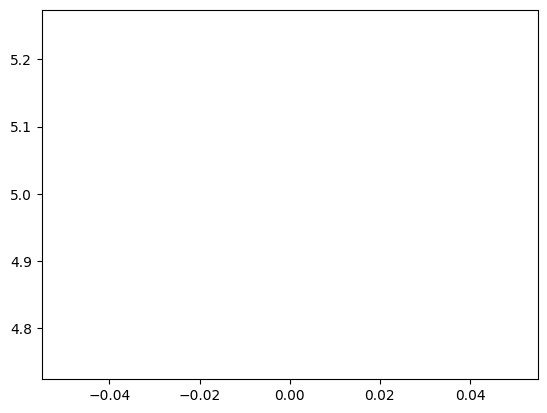

In [123]:
plt.plot(losses)